In [1]:
"""
This file contained the feature-based similarity search method using two-layer neural network

Created by Zexi Chen(zchen22)
Date: Oct 2, 2016
"""

import numpy
import six.moves.cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from Feature_based_similarity_search import loadData, dtw, euclideanDist, NeuNet
%matplotlib inline

In [2]:
# read the data and rescale to 0-1
train_set = loadData('../theano/data/samples1')
valid_set = loadData('../theano/data/samples2')
test_set = loadData('../theano/data/samples3')

# reshape the array, concatenate two time series as one training instance
train_set_reshape = numpy.reshape(train_set, (train_set.shape[0]/2, train_set.shape[1]*2))
valid_set_reshape = numpy.reshape(valid_set, (valid_set.shape[0]/2, valid_set.shape[1]*2))
test_set_reshape = numpy.reshape(test_set, (test_set.shape[0]/2, test_set.shape[1]*2))

# re-scale input data
train_set1 = train_set_reshape/255.0
valid_set1 = valid_set_reshape/255.0
test_set1 = test_set_reshape/255.0

In [3]:
def generateTrainData(train_set, numInstance):
    sampleIndices = numpy.random.choice(train_set.shape[0], 2 * numInstance)
    train_set_samples = train_set[sampleIndices]
    train_set_reshape = numpy.reshape(train_set_samples, (train_set_samples.shape[0]/2, train_set_samples.shape[1]*2))
    train_set1 = train_set_reshape/255.0
    train_dtws = numpy.zeros((train_set1.shape[0],1))
    for i in range(train_set1.shape[0]):
        train_dtws[i,0] = dtw(train_set1[i,0:23], train_set1[i,23:])**2
    
    return train_set1, train_dtws

In [4]:
# calculate the squared dtw distance between the two time series in each row of the training data validation data and test data 
# the dtw is used in the cost function as the target value to minimize.
train_dtws = numpy.zeros((train_set1.shape[0],1))
for i in range(train_set1.shape[0]):
    train_dtws[i,0] = dtw(train_set1[i,0:23], train_set1[i,23:])**2

valid_dtws = numpy.zeros((valid_set1.shape[0],1))
for i in range(valid_set1.shape[0]):
    valid_dtws[i,0] = dtw(valid_set1[i,0:23], valid_set1[i,23:])**2

test_dtws = numpy.zeros((test_set1.shape[0],1))
for i in range(test_set1.shape[0]):
    test_dtws[i,0] = dtw(test_set1[i,0:23], test_set1[i,23:])**2

In [5]:
# build the neural network model
# start the tensorflow interaction interface
sess = tf.InteractiveSession()

In [6]:
n_hiddens = [100,50]
learning_rate = [1e-2]
training_epochs = 10000

# create two variable placehold, x for the training features, 
# y for the labels(in this model it is the dtw distance between two time series)
x = tf.placeholder(tf.float32, shape=[None, train_set.shape[1]*2])
y = tf.placeholder(tf.float32, shape=[None, 1])

nn1 = NeuNet(
    None,
    None,
    input = x,
    activation = tf.nn.sigmoid,
    n_visible = train_set.shape[1]*2,
    n_hidden =  n_hiddens[0]
)

nn2 = NeuNet(
    None,
    None,
    input = nn1.output,
    activation = tf.nn.sigmoid,
    n_visible = n_hiddens[0]*2,
    n_hidden = n_hiddens[1]
)

In [8]:
# compute the cost and minimize it
cost = nn2.cost_function(y)
train_step = tf.train.AdamOptimizer(learning_rate[0]).minimize(cost)

sess.run(tf.initialize_all_variables())

In [9]:
# run the model
train_error = []
valid_error = []
best_valid_error = numpy.inf
numInstance = 1000
for i in range(training_epochs):
    sample_train_set, sample_train_dtws = generateTrainData(train_set, numInstance)
    #sess.run([train_step], feed_dict={x:train_set1, y:train_dtws})
    sess.run([train_step], feed_dict={x:sample_train_set, y:sample_train_dtws})
    if i%100 == 0:
        #train_err = sess.run([cost],feed_dict={x:train_set1, y:train_dtws})
        train_err = sess.run([cost],feed_dict={x:sample_train_set, y:sample_train_dtws})
        train_error.append(train_err)
        valid_err = sess.run([cost],feed_dict={x:valid_set1, y:valid_dtws})
        valid_error.append(valid_err)
        print("step %d, the mean error of the training data %g, vilidation data %g"%(i, train_error[-1][0], valid_error[-1][0]))
        #print h_conv1_flat.eval(feed_dict={x:test_set1})
        if valid_error[-1][0] < best_valid_error * 0.995:
            W_1 = sess.run(nn1.W)
            b_1 = sess.run(nn1.b)
            W_2 = sess.run(nn2.W)
            b_2 = sess.run(nn2.b)
            best_valid_error = valid_error[-1][0]

step 0, the mean error of the training data 1538.73, vilidation data 16.3377
step 100, the mean error of the training data 724.258, vilidation data 13.014
step 200, the mean error of the training data 598.215, vilidation data 11.7895
step 300, the mean error of the training data 646.972, vilidation data 11.8228
step 400, the mean error of the training data 536.198, vilidation data 10.7018
step 500, the mean error of the training data 712.139, vilidation data 11.1575
step 600, the mean error of the training data 660.817, vilidation data 10.9014
step 700, the mean error of the training data 563.082, vilidation data 10.984
step 800, the mean error of the training data 596.907, vilidation data 11.0111
step 900, the mean error of the training data 702.305, vilidation data 11.0759
step 1000, the mean error of the training data 761.268, vilidation data 10.9947
step 1100, the mean error of the training data 636.86, vilidation data 11.2117
step 1200, the mean error of the training data 599.924,

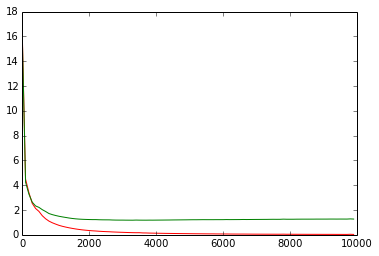

In [32]:
# plot the training error and validation error
Xaxis = [x * 100 for x in range(training_epochs/100)]
plt.plot(Xaxis, train_error, 'r',label='train error')
plt.plot(Xaxis, valid_error, 'g',label='validation error')
plt.show()

In [33]:
# rescale the test dataset
test_set_rescale = test_set/255.0

In [34]:
# reshape the W matrix to [23,10]
W_1_prime = numpy.reshape(W_1,[23, n_hiddens[0]])
hidden_1 = sess.run(tf.nn.sigmoid(numpy.matmul(test_set,W_1_prime)+b_1))
W_2_prime = numpy.reshape(W_2,[n_hiddens[0], n_hiddens[1]])
hidden_2 = tf.nn.sigmoid(numpy.matmul(hidden_1,W_2_prime)+b_2)

In [35]:
test_features = sess.run(hidden_2)

In [36]:
test_features

array([[  7.31389595e-04,   3.00213336e-01,   3.92834803e-08, ...,
          5.68614611e-06,   8.96090016e-08,   9.99999995e-01],
       [  3.68367495e-03,   4.81400907e-02,   1.47490099e-07, ...,
          2.79448862e-04,   7.43867452e-10,   9.99999998e-01],
       [  2.15633719e-02,   6.91853551e-01,   7.66902298e-08, ...,
          3.49492491e-04,   2.68738344e-07,   9.99999996e-01],
       ..., 
       [  1.03478008e-07,   6.96087231e-03,   3.79815705e-07, ...,
          7.08011699e-05,   4.43131962e-08,   1.00000000e+00],
       [  2.26550830e-06,   9.88732801e-01,   1.12894150e-12, ...,
          4.50474864e-01,   9.47424102e-02,   9.99999959e-01],
       [  4.47279438e-03,   9.21517615e-01,   1.66548059e-08, ...,
          9.99780025e-01,   8.29811371e-01,   9.99999995e-01]])

In [44]:
# evaluate function
def evaluateFunc(num, ori_set, new_set, nn, nNeighbor=100):
    '''
        num: the number of sample time series we use to evaluate the performance of our neural network model
        ori_set: it is the original dataset
        new_set: this is the dataset generated after we perform our neural network model on our original dataset
        nn: the number of time series we use to calculate the dtw and euclidean distance
        nNeighbor: the number of neighbors we extracted to compare the overlap between dtw and euclidean distances
    '''
    result = []
    for n in range(num):
        euclidean_dists = []
        dtw_dists = []
        for i in range(nn):
            dtw_dists.append((i,dtw(ori_set[i], ori_set[nn + n])))
            euclidean_dists.append((i, euclideanDist(new_set[i], new_set[nn + n])))
        euclidean_dists_sorted = sorted(euclidean_dists, key=(lambda x: x[1]))
        dtw_dists_sorted = sorted(dtw_dists, key=(lambda x: x[1]))
        euclid_set = set()
        dtw_set = set()
        for i in range(nNeighbor):
            euclid_set.add(euclidean_dists_sorted[i][0])
            dtw_set.add(dtw_dists_sorted[i][0])
        count = 0
        for x in euclid_set:
            if x in dtw_set:
                count += 1
        result.append(float(count)/nNeighbor)
    return reduce(lambda x, y: x + y, result)/len(result)

In [45]:
perform = evaluateFunc(100, test_set_rescale, test_features, 1000)

In [46]:
print perform

0.3081
